# GENERALIZED END-TO-END LOSS FOR SPEAKER VERIFICATION

https://arxiv.org/pdf/1710.10467.pdf

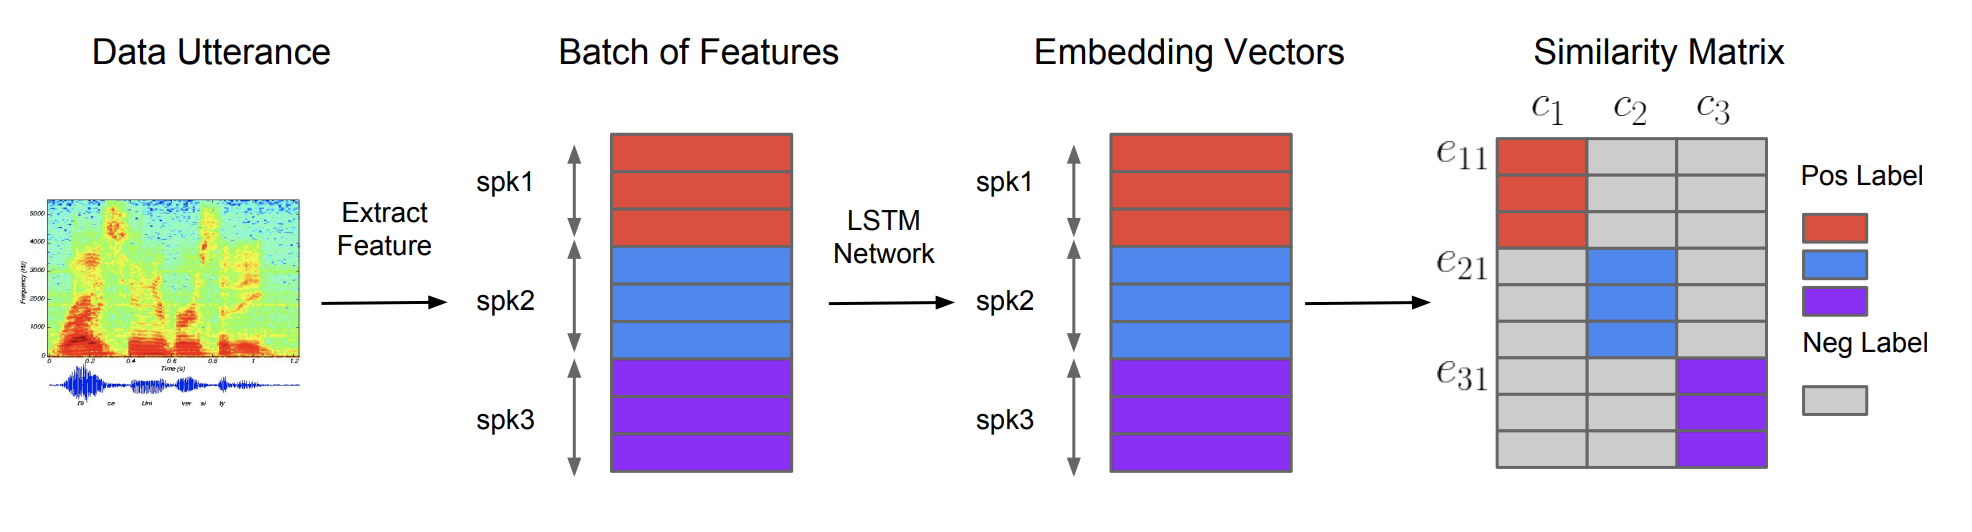

$$
\mathbf{e}_{j i}=\frac{f\left(\mathbf{x}_{j i} ; \mathbf{w}\right)}{\left\|f\left(\mathbf{x}_{j i} ; \mathbf{w}\right)\right\|_{2}} \\
\mathbf{c}_{k}=\mathbb{E}_{m}\left[\mathbf{e}_{k m}\right]=\frac{1}{M} \sum_{m=1}^{M} \mathbf{e}_{k m} \\
\mathbf{S}_{j i, k}=w \cdot \cos \left(\mathbf{e}_{j i}, \mathbf{c}_{k}\right)+b \\
L\left(\mathbf{e}_{j i}\right)=-\mathbf{S}_{j i, j}+\log \sum_{k=1}^{N} \exp \left(\mathbf{S}_{j i, k}\right)
$$

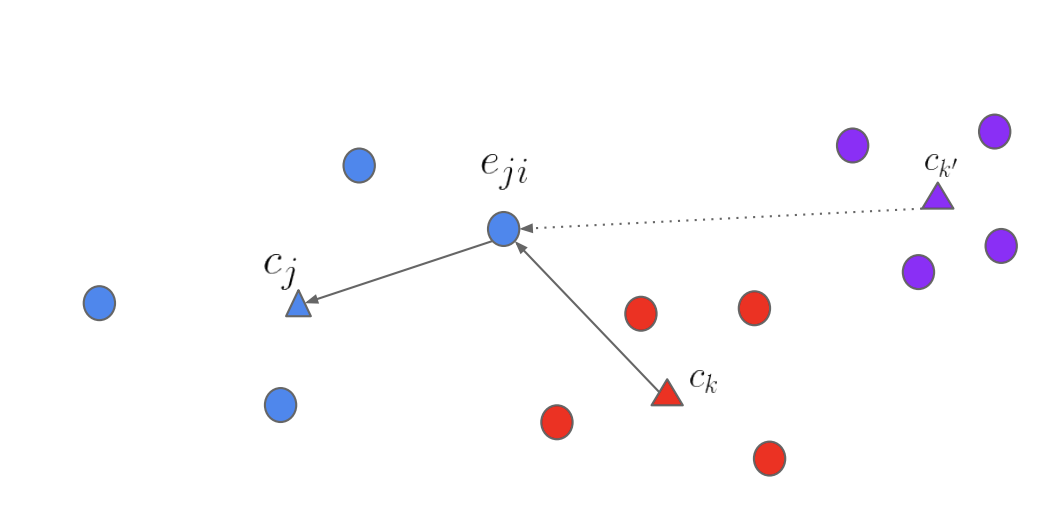

## Implementation of GE2E

In [1]:
# !pip install resemblyzer
# !git clone https://github.com/resemble-ai/Resemblyzer.git

In [2]:
%pylab inline

import pathlib
from itertools import groupby
from collections import defaultdict
from tqdm import tqdm
from IPython import display

from resemblyzer import preprocess_wav, VoiceEncoder

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
_default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

def plot_similarity_matrix(matrix, labels_a=None, labels_b=None, ax: plt.Axes=None, title=""):
    if ax is None:
        _, ax = plt.subplots()
    fig = plt.gcf()
        
    img = ax.matshow(matrix, extent=(-0.5, matrix.shape[0] - 0.5, 
                                     -0.5, matrix.shape[1] - 0.5))

    ax.xaxis.set_ticks_position("bottom")
    if labels_a is not None:
        ax.set_xticks(range(len(labels_a)))
        ax.set_xticklabels(labels_a, rotation=90)
    if labels_b is not None:
        ax.set_yticks(range(len(labels_b)))
        ax.set_yticklabels(labels_b[::-1])  # Upper origin -> reverse y axis
    ax.set_title(title)

    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.15)
    fig.colorbar(img, cax=cax, ticks=np.linspace(0.4, 1, 7))
    img.set_clim(0.4, 1)
    img.set_cmap("inferno")
    
    return ax

def plot_histograms(all_samples, ax=None, names=None, title=""):
    """
    Plots (possibly) overlapping histograms and their median 
    """
    if ax is None:
        _, ax = plt.subplots()
    
    for samples, color, name in zip(all_samples, _default_colors, names):
        ax.hist(samples, density=True, color=color + "80", label=name)
    ax.legend()
    ax.set_xlim(0.35, 1)
    ax.set_yticks([])
    ax.set_title(title)
        
    ylim = ax.get_ylim()
    ax.set_ylim(*ylim)      # Yeah, I know
    for samples, color in zip(all_samples, _default_colors):
        median = np.median(samples)
        ax.vlines(median, *ylim, color, "dashed")
        ax.text(median, ylim[1] * 0.15, "median", rotation=270, color=color)
    
    return ax

## Similarity between speakers

In [4]:
encoder = VoiceEncoder()

Loaded the voice encoder model on cpu in 0.07 seconds.


In [5]:
wav_fpaths = list(pathlib.Path("Resemblyzer/audio_data/", "librispeech_test-other").glob("**/*.flac"))
speaker_wavs = defaultdict(list)

for speaker, wav_fpaths in groupby(wav_fpaths, key=lambda wav_fpath: wav_fpath.parent.stem):
    for wav in wav_fpaths:
        speaker_wavs[speaker].append(preprocess_wav(str(wav)))

### Similarity between two utterances from each speaker

In [6]:
embeds_a = np.array([encoder.embed_utterance(wavs[0]) for wavs in speaker_wavs.values()])
embeds_b = np.array([encoder.embed_utterance(wavs[1]) for wavs in speaker_wavs.values()])
utt_sim_matrix = np.inner(embeds_a, embeds_b)

In [7]:
print("Shape of embeddings: %s" % str(embeds_a.shape))

Shape of embeddings: (10, 256)


### Similarity between two speaker embeddings

In [8]:
spk_embeds_a = np.array([encoder.embed_speaker(wavs[:len(wavs) // 2]) \
                         for wavs in speaker_wavs.values()])
spk_embeds_b = np.array([encoder.embed_speaker(wavs[len(wavs) // 2:]) \
                         for wavs in speaker_wavs.values()])
spk_sim_matrix = np.inner(spk_embeds_a, spk_embeds_b)

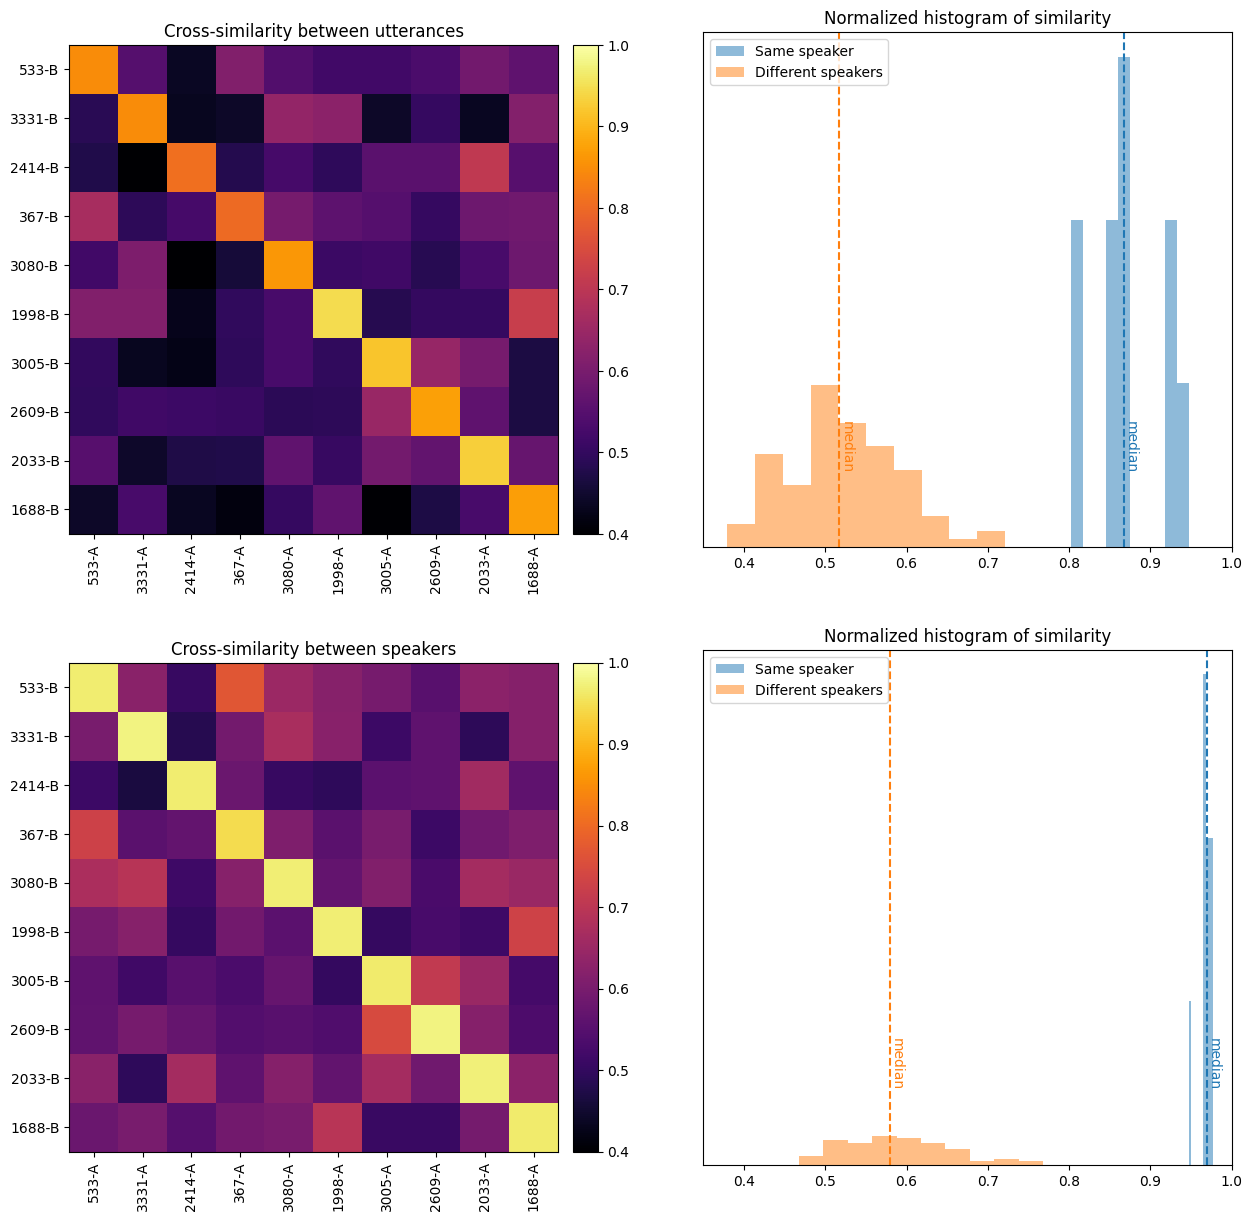

In [9]:
fix, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=100)

labels_a = ["%s-A" % i for i in speaker_wavs.keys()]
labels_b = ["%s-B" % i for i in speaker_wavs.keys()]

mask = np.eye(len(utt_sim_matrix), dtype=np.bool)

plot_similarity_matrix(utt_sim_matrix,  labels_a, labels_b, axs[0, 0],
                       "Cross-similarity between utterances")
plot_histograms((utt_sim_matrix[mask], utt_sim_matrix[np.logical_not(mask)]), axs[0, 1],
                ["Same speaker", "Different speakers"],
                "Normalized histogram of similarity")

plot_similarity_matrix(spk_sim_matrix, labels_a, labels_b, axs[1, 0],
                       "Cross-similarity between speakers")

plot_histograms((spk_sim_matrix[mask], spk_sim_matrix[np.logical_not(mask)]), axs[1, 1],
                ["Same speaker", "Different speakers"],
                "Normalized histogram of similarity")

plt.show()